# About Dataset

RowNumber—corresponds to the record (row) number and has no effect on the output.

CustomerId—contains random values and has no effect on customer leaving the bank.

Surname—the surname of a customer has no impact on their decision to leave the bank.

CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

Geography—a customer’s location can affect their decision to leave the bank.

Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.

Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

NumOfProducts—refers to the number of products that a customer has purchased through the bank.

HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.

IsActiveMember—active customers are less likely to leave the bank.

EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

Exited—whether or not the customer left the bank.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [451]:
data = pd.read_csv('churn.csv')
data.drop('RowNumber', axis=1, inplace=True)
data.drop('CustomerId', axis=1, inplace=True)
data.drop('Surname', axis=1, inplace=True)

data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### Analisis hubungan fitur 

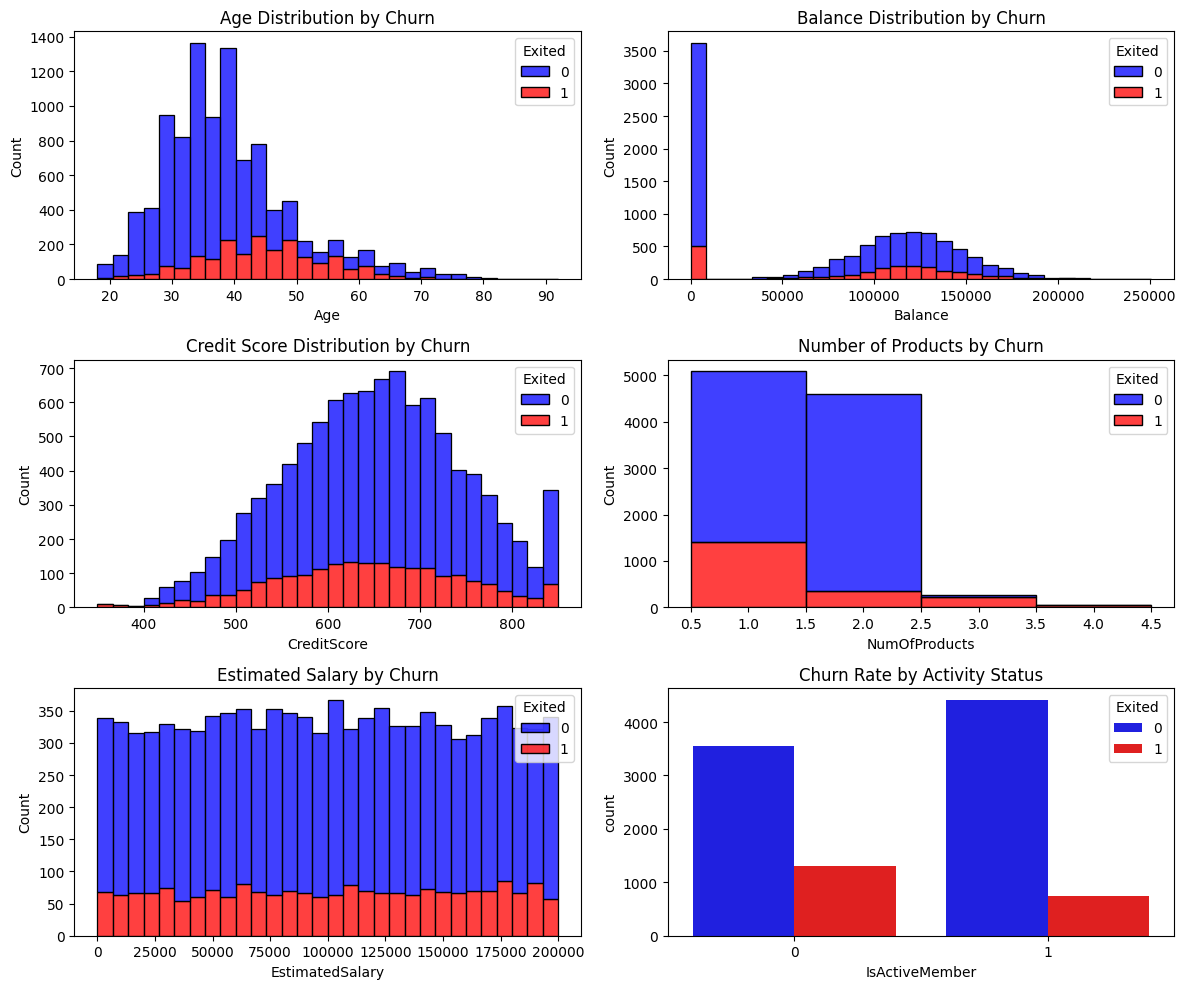

In [452]:
# Bandingkan statistik antara nasabah churn (Exited = 1) dan tidak churn (Exited = 0)
numeric_columns = data.select_dtypes(include=[np.number]).columns
churn_stats = data.groupby("Exited")[numeric_columns].mean()

# Visualisasi distribusi beberapa fitur utama
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Plot distribusi untuk fitur utama yang mungkin membedakan churn
sns.histplot(data, x="Age", hue="Exited", multiple="stack", bins=30, ax=axes[0, 0], palette=["blue", "red"])
axes[0, 0].set_title("Age Distribution by Churn")

sns.histplot(data, x="Balance", hue="Exited", multiple="stack", bins=30, ax=axes[0, 1], palette=["blue", "red"])
axes[0, 1].set_title("Balance Distribution by Churn")

sns.histplot(data, x="CreditScore", hue="Exited", multiple="stack", bins=30, ax=axes[1, 0], palette=["blue", "red"])
axes[1, 0].set_title("Credit Score Distribution by Churn")

sns.histplot(data, x="NumOfProducts", hue="Exited", multiple="stack", bins=4, discrete=True, ax=axes[1, 1], palette=["blue", "red"])
axes[1, 1].set_title("Number of Products by Churn")

sns.histplot(data, x="EstimatedSalary", hue="Exited", multiple="stack", bins=30, ax=axes[2, 0], palette=["blue", "red"])
axes[2, 0].set_title("Estimated Salary by Churn")

sns.countplot(x="IsActiveMember", hue="Exited", data=data, ax=axes[2, 1], palette=["blue", "red"])
axes[2, 1].set_title("Churn Rate by Activity Status")

plt.tight_layout()
plt.show()



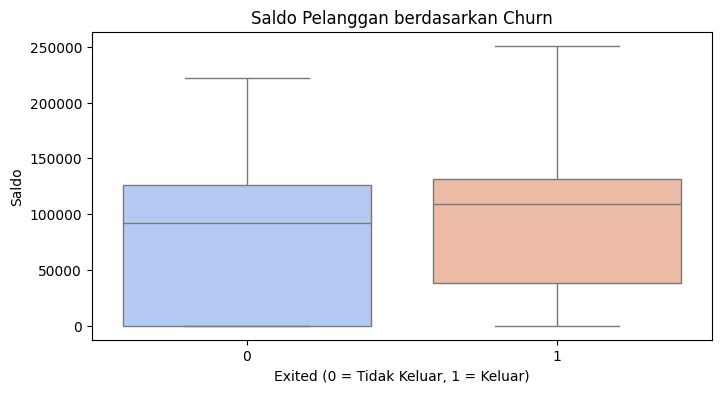

In [453]:
# Boxplot saldo berdasarkan churn
plt.figure(figsize=(8, 4))
sns.boxplot(x="Exited", y="Balance", data=data, palette="coolwarm")
plt.title("Saldo Pelanggan berdasarkan Churn")
plt.xlabel("Exited (0 = Tidak Keluar, 1 = Keluar)")
plt.ylabel("Saldo")
plt.show()

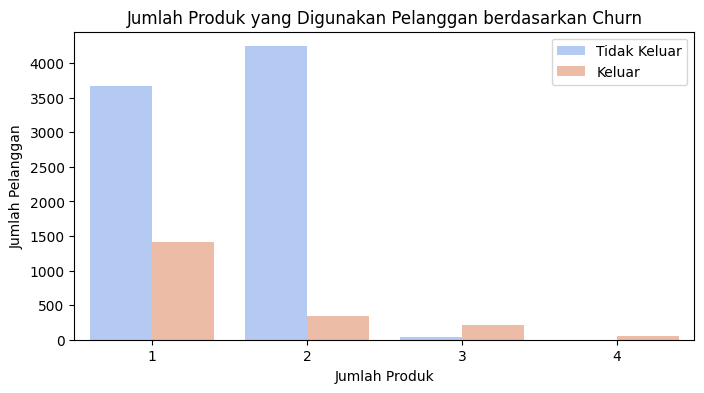

In [454]:
# Distribusi jumlah produk berdasarkan churn
plt.figure(figsize=(8, 4))
sns.countplot(x="NumOfProducts", hue="Exited", data=data, palette="coolwarm")
plt.title("Jumlah Produk yang Digunakan Pelanggan berdasarkan Churn")
plt.xlabel("Jumlah Produk")
plt.ylabel("Jumlah Pelanggan")
plt.legend(["Tidak Keluar", "Keluar"])
plt.show()

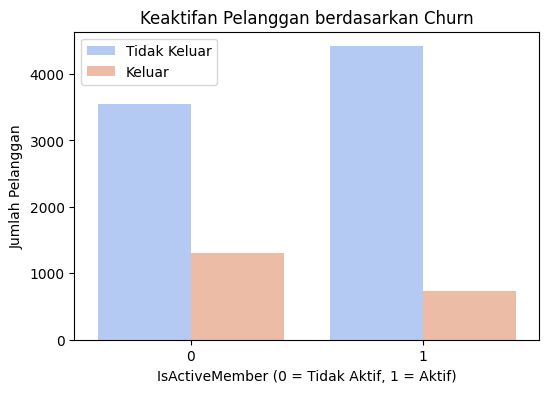

In [455]:
# Status keaktifan pelanggan berdasarkan churn
plt.figure(figsize=(6, 4))
sns.countplot(x="IsActiveMember", hue="Exited", data=data, palette="coolwarm")
plt.title("Keaktifan Pelanggan berdasarkan Churn")
plt.xlabel("IsActiveMember (0 = Tidak Aktif, 1 = Aktif)")
plt.ylabel("Jumlah Pelanggan")
plt.legend(["Tidak Keluar", "Keluar"])
plt.show()

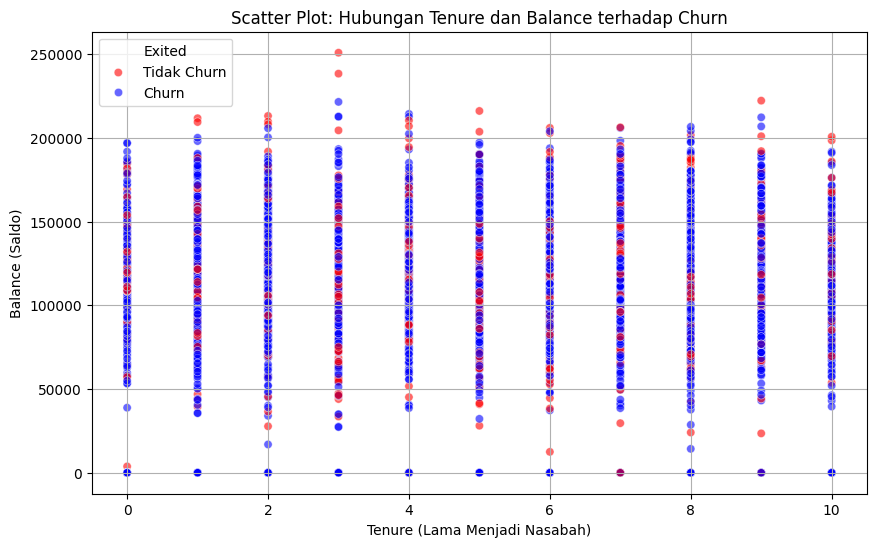

In [456]:
# Scatter plot untuk melihat hubungan antara Tenure dan Balance dengan Churn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="Tenure", y="Balance", hue="Exited", alpha=0.6, palette={0: "blue", 1: "red"})
plt.title("Scatter Plot: Hubungan Tenure dan Balance terhadap Churn")
plt.xlabel("Tenure (Lama Menjadi Nasabah)")
plt.ylabel("Balance (Saldo)")
plt.legend(title="Exited", labels=["Tidak Churn", "Churn"])
plt.grid(True)
plt.show()

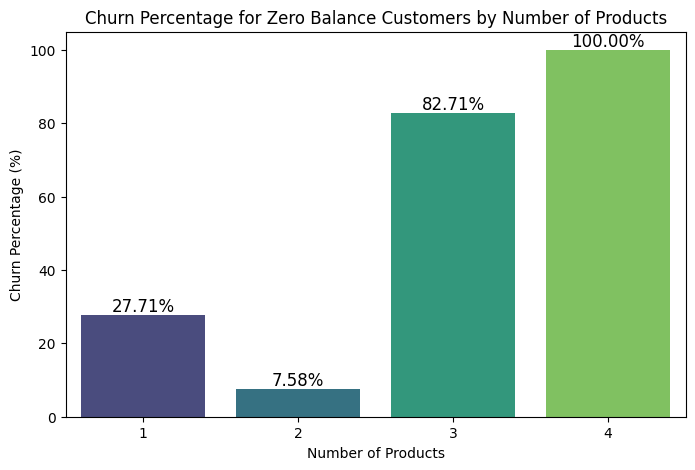

In [457]:
# Hitung persentase churn berdasarkan NumOfProducts untuk nasabah dengan saldo 0
churn_by_products = data.groupby("NumOfProducts")["Exited"].mean() * 100

# Buat plot
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_by_products.index, y=churn_by_products.values, palette="viridis")
plt.xlabel("Number of Products")
plt.ylabel("Churn Percentage (%)")
plt.title("Churn Percentage for Zero Balance Customers by Number of Products")

# Tampilkan persentase di atas batang
for i, v in enumerate(churn_by_products.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=12)

plt.show()


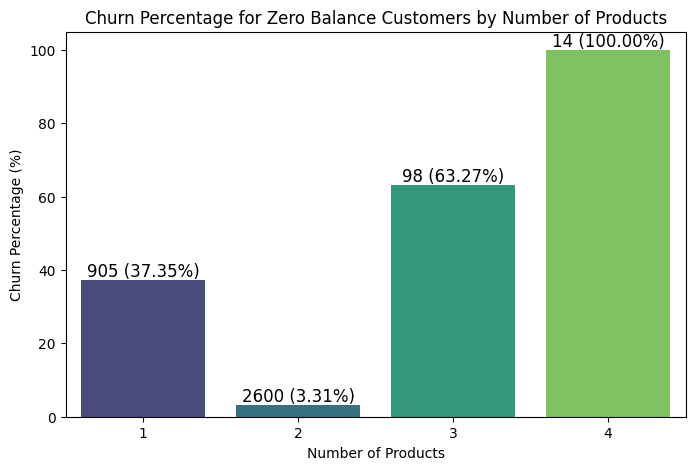

In [458]:
# Filter nasabah dengan Balance = 0
zero_balance_customers = data[data["Balance"] == 0]

# Hitung jumlah total nasabah dan jumlah churn berdasarkan NumOfProducts
total_customers_by_products = zero_balance_customers.groupby("NumOfProducts")["Exited"].count()
churn_counts_by_products = zero_balance_customers.groupby("NumOfProducts")["Exited"].sum()
churn_percentage_by_products = (churn_counts_by_products / total_customers_by_products) * 100

# Buat plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=total_customers_by_products.index, y=churn_percentage_by_products.values, palette="viridis")
plt.xlabel("Number of Products")
plt.ylabel("Churn Percentage (%)")
plt.title("Churn Percentage for Zero Balance Customers by Number of Products")

# Tampilkan angka total nasabah dan persentase di atas batang
for i, (total, percent) in enumerate(zip(total_customers_by_products, churn_percentage_by_products)):
    plt.text(i, percent + 1, f"{total} ({percent:.2f}%)", ha='center', fontsize=12)

plt.show()


### Feature Engineering

In [459]:
# 1. Segmentasi Risiko (RiskSegment)
data["RiskSegment"] = data.apply(lambda row: "High Risk" if row["Tenure"] <= 3 and row["Balance"] > data["Balance"].median() 
                              else "Medium Risk" if row["Tenure"] <= 6 or row["Balance"] > data["Balance"].median() 
                              else "Low Risk", axis=1)

# 2. Skor Keterlibatan Produk (ProductEngagement)
data["ProductEngagement"] = (data["NumOfProducts"] / data["NumOfProducts"].max()) + (data["HasCrCard"] * 0.2)

# 3. Skor Stabilitas Keuangan (FinancialStabilityScore)
data["FinancialStabilityScore"] = (data["Balance"] / data["Balance"].max()) + (data["EstimatedSalary"] / data["EstimatedSalary"].max())

# 4. Tenure Ratio (lama menjadi nasabah dibandingkan rata-rata tenure)
data["TenureRatio"] = data["Tenure"] / data["Tenure"].mean()

# 5. Is High Risk (Saldo 0, skor kredit rendah, dan tidak aktif) Indikator risiko tinggi berdasarkan saldo 0, skor kredit rendah, dan tidak aktif.
low_credit_threshold = data["CreditScore"].quantile(0.25)  # Ambil quartile 25% sebagai batas rendah
data["IsHighRisk"] = ((data["Balance"] == 0) & (data["CreditScore"] <= low_credit_threshold) & (data["IsActiveMember"] == 0)).astype(int)

# 6. IsSeniorCustomer (Usia di atas 40 tahun) Usia lebih tua → Churn lebih tinggi
data["IsSeniorCustomer"] = (data["Age"] > 40).astype(int)

# 7. HighBalanceCustomer (Saldo lebih dari rata-rata churn) Rata-rata saldo nasabah churn = 91,108, Rata-rata saldo nasabah tidak churn = 72,745
balance_threshold = data[data["Exited"] == 1]["Balance"].mean()
data["HighBalanceCustomer"] = (data["Balance"] > balance_threshold).astype(int)

# 8. InactiveHighRisk (Nasabah tidak aktif dan memiliki saldo tinggi) Nasabah yang tidak aktif ("Not Active") memiliki churn rate lebih tinggi (~36%)
data["InactiveHighRisk"] = ((data["IsActiveMember"] == 0) & (data["Balance"] > balance_threshold)).astype(int)

# 9. Kategorisasi Credit Score
def categorize_credit_score(score):
    if score >= 800:
        return "Excellent"
    elif score >= 740:
        return "Very Good"
    elif score >= 670:
        return "Good"
    elif score >= 580:
        return "Fair"
    else:
        return "Poor"

data["CreditScoreCategory"] = data["CreditScore"].apply(categorize_credit_score)

# # Data eksternal terkait ekonomi per negara (bisa didapat dari World Bank, IMF, atau OECD)
# economic_data = {
#     "Geography": ["Germany", "France", "Spain"],
#     "GDP_per_capita": [52746, 44461, 32677],   # GDP dalam USD
#     "Interest_rate": [2.5, 3.3, 2.8],          # Suku bunga dalam %
#     "Inflation_rate": [2.7, 1.4, 2.9]          # Inflasi dalam %
# }
# 
# # Konversi ke DataFrame
# df_econ = pd.DataFrame(economic_data)
# 
# # Merge data ekonomi ke dalam dataset utama
# data = data.merge(df_econ, on="Geography", how="left")

data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,RiskSegment,ProductEngagement,FinancialStabilityScore,TenureRatio,IsHighRisk,IsSeniorCustomer,HighBalanceCustomer,InactiveHighRisk,CreditScoreCategory
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Medium Risk,0.45,0.506763,0.398979,0,1,0,0,Fair
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Medium Risk,0.25,0.896766,0.199489,0,1,0,0,Fair
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Medium Risk,0.95,1.206036,1.595914,0,1,1,1,Poor
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Medium Risk,0.50,0.469151,0.199489,0,0,0,0,Good
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,High Risk,0.45,0.895682,0.398979,0,1,1,0,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,Medium Risk,0.70,0.481371,0.997447,0,0,0,0,Very Good
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,Low Risk,0.45,0.737175,1.994893,0,0,0,0,Poor
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,Low Risk,0.25,0.210436,1.396425,0,0,0,0,Good
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,Medium Risk,0.70,0.763686,0.598468,0,1,0,0,Very Good


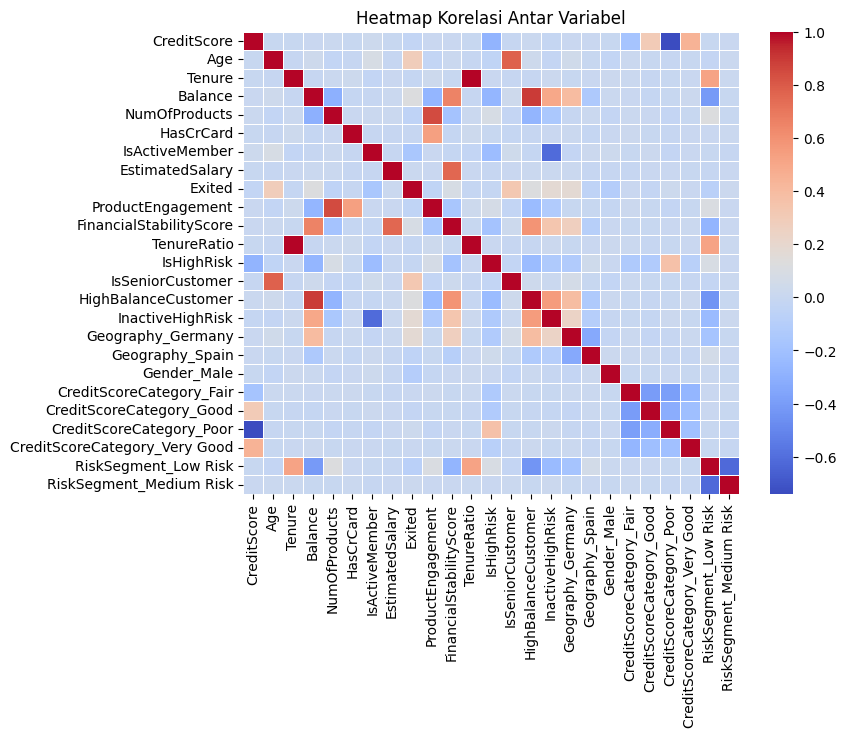

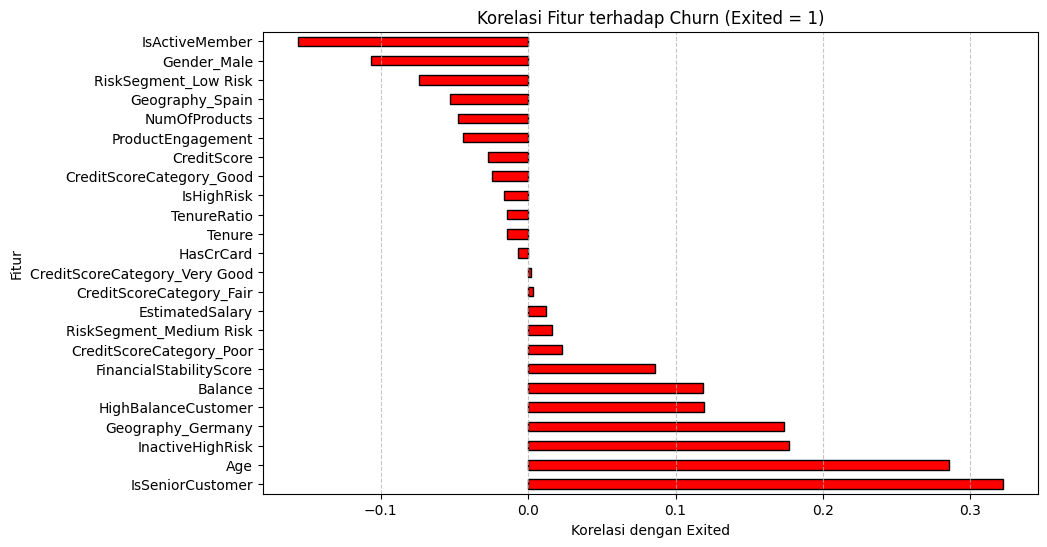

In [460]:
df_model = data

# Encoding variabel kategori
df_model = pd.get_dummies(df_model, columns=["Geography", "Gender","CreditScoreCategory","RiskSegment"], drop_first=True)

df_model

# Buat heatmap tanpa angka
plt.figure(figsize=(8, 6))
sns.heatmap(df_model.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

# Hitung korelasi dengan kolom 'Exited'
correlation = df_model.corr()["Exited"].sort_values(ascending=False)

# Buat horizontal bar chart
plt.figure(figsize=(10, 6))
correlation[1:].plot(kind="barh", color="red", edgecolor="black")  # Exclude 'Exited' itself
plt.title("Korelasi Fitur terhadap Churn (Exited = 1)")
plt.xlabel("Korelasi dengan Exited")
plt.ylabel("Fitur")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()



Logistic Regression Model:
  Accuracy: 78.05%
  F1 Score: 0.54
  ROC-AUC Score: 0.79
  Best Threshold: 0.60
  Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1593
           1       0.47      0.62      0.54       407

    accuracy                           0.78      2000
   macro avg       0.68      0.72      0.70      2000
weighted avg       0.81      0.78      0.79      2000


Decision Tree Model:
  Accuracy: 78.50%
  F1 Score: 0.47
  ROC-AUC Score: 0.67
  Best Threshold: 0.10
  Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      1593
           1       0.47      0.47      0.47       407

    accuracy                           0.79      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.79      0.79      0.79      2000


Random Forest Model:
  Accuracy: 85.50%
  F1 Score: 0.63
  ROC-AUC Score: 0.85
  

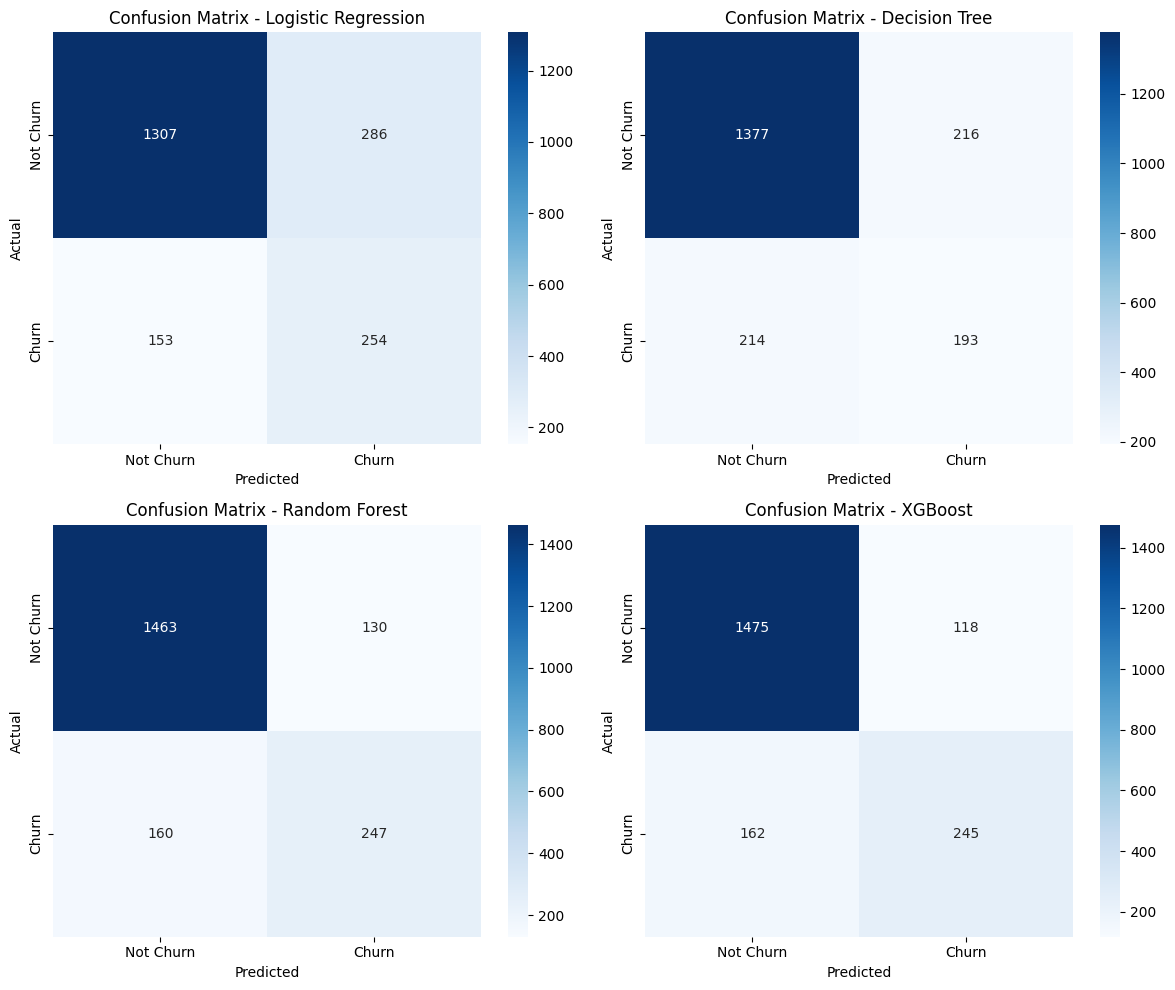

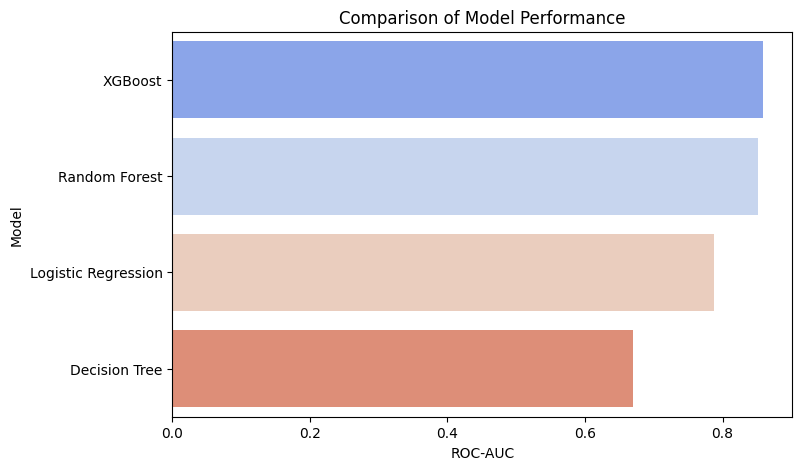

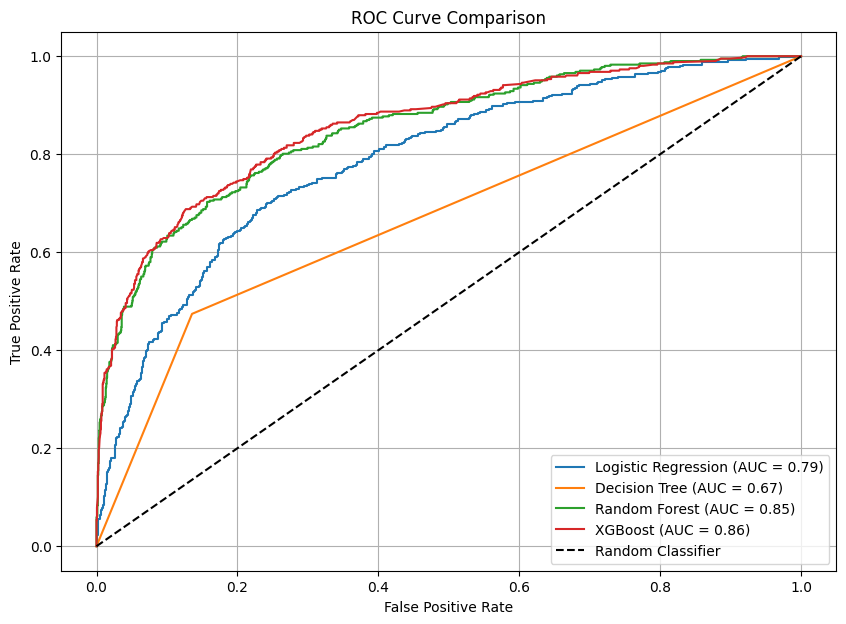

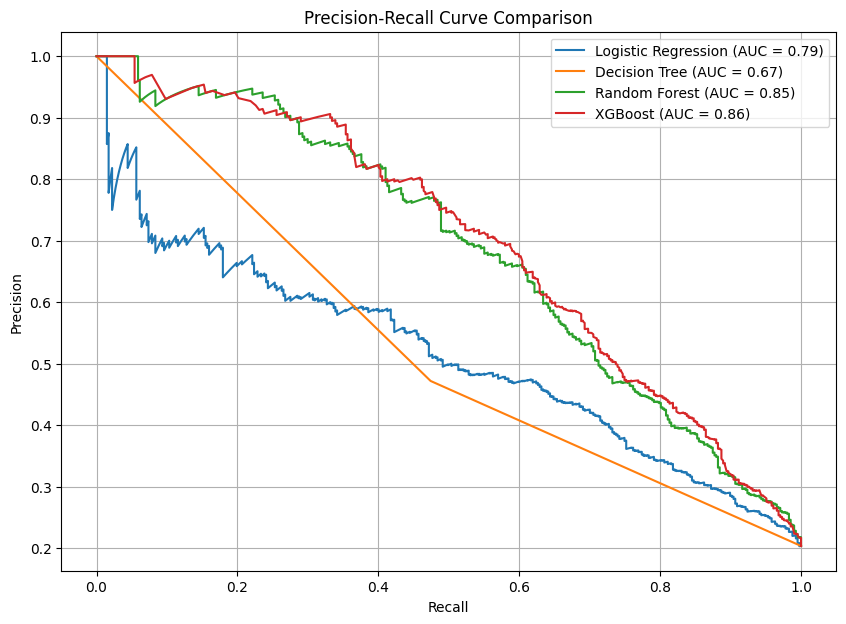

In [461]:
# Separate features (X) and target variable (y)
X = df_model.drop(columns=["Exited"])  # Drop the target column from features
y = df_model["Exited"]  # Store the target column for predictions

# Split data into training (80%) and testing (20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalize training features
X_test_scaled = scaler.transform(X_test)  # Normalize testing features

# Initialize 10-fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## F1 Score is the harmonic mean of recall and precision, giving a balanced picture between the two metrics. 
## This is useful when there is a need to minimize False Positives and False Negatives equally.
# Function to find the best threshold based on F1-score
def find_best_threshold(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]  # Get probability of positive class
    best_threshold, best_f1 = 0.5, 0  # Initialize best threshold
    thresholds = np.arange(0.1, 0.9, 0.01)  # Range of thresholds from 0.1 to 0.9
    
    # Iterate to find the best threshold with the highest F1-score
    for t in thresholds:
        preds = (probs >= t).astype(int)  # Convert probabilities to labels based on threshold
        f1 = f1_score(y_test, preds)  # Compute F1-score
        if f1 > best_f1:
            best_f1, best_threshold = f1, t  # Update best threshold
    return best_threshold

# =================================================================================================================
# 1. Logistic Regression
# =================================================================================================================
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}  # Regularization parameter C
grid_lr = GridSearchCV(lr, param_grid_lr, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)  # Train Logistic Regression with normalized data
best_lr = grid_lr.best_estimator_  # Best model from GridSearchCV
best_threshold_lr = find_best_threshold(best_lr, X_test_scaled, y_test)  # Find best threshold

# =================================================================================================================
# 2. Decision Tree
# =================================================================================================================
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid_dt = {
    'max_depth': [3, 5, 10, None],  # Maximum tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples required for a split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)  # Train Decision Tree model
best_dt = grid_dt.best_estimator_  # Best model
best_threshold_dt = find_best_threshold(best_dt, X_test, y_test)  # Find best threshold

# =================================================================================================================
# 3. Random Forest
# =================================================================================================================
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum tree depth
    'min_samples_split': [2, 5],  # Minimum samples required for a split
    'min_samples_leaf': [1, 2]  # Minimum samples per leaf
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)  # Train Random Forest model
best_rf = grid_rf.best_estimator_  # Best model
best_threshold_rf = find_best_threshold(best_rf, X_test, y_test)  # Find best threshold

# =================================================================================================================
# 4. XGBoost
# =================================================================================================================
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=2)
param_grid_xgb = {
    'n_estimators': [100, 200],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate for gradient boosting
    'max_depth': [3, 6, 10]  # Maximum tree depth
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)  # Train XGBoost model
best_xgb = grid_xgb.best_estimator_  # Best model
best_threshold_xgb = find_best_threshold(best_xgb, X_test, y_test)  # Find best threshold


# =================================================================================================================
# Model Evaluation and Confusion Matrix
# =================================================================================================================
models = {
    "Logistic Regression": (best_lr, X_test_scaled, best_threshold_lr),
    "Decision Tree": (best_dt, X_test, best_threshold_dt),
    "Random Forest": (best_rf, X_test, best_threshold_rf),
    "XGBoost": (best_xgb, X_test, best_threshold_xgb),
}

results = []
plt.figure(figsize=(12, 10))

for i, (name, (model, X_data, threshold)) in enumerate(models.items()):
    probs = model.predict_proba(X_data)[:, 1]  # Probability of positive class
    y_pred = (probs >= threshold).astype(int)  # Convert to labels based on threshold
    
    acc = accuracy_score(y_test, y_pred)  # Model accuracy
    f1 = f1_score(y_test, y_pred)  # F1-score
    roc_auc = roc_auc_score(y_test, probs)  # ROC-AUC score

    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1, "ROC-AUC": roc_auc, "Best Threshold": threshold})

    print(f"\n{name} Model:")
    print(f"  Accuracy: {acc:.2%}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  ROC-AUC Score: {roc_auc:.2f}")
    print(f"  Best Threshold: {threshold:.2f}")
    print("  Classification Report:\n", classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.show()

# =================================================================================================================
# Model Comparison
# =================================================================================================================
df_results = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)  # Sort by ROC-AUC
plt.figure(figsize=(8, 5))
sns.barplot(x="ROC-AUC", y="Model", data=df_results, palette="coolwarm")  # Plot model comparison
plt.title("Comparison of Model Performance")
plt.show()

# =================================================================================================================
# Plot ROC Curve for all models
# =================================================================================================================
plt.figure(figsize=(10, 7))

for name, (model, X_data, _) in models.items():
    probs = model.predict_proba(X_data)[:, 1]  # Get predicted probabilities
    fpr, tpr, _ = roc_curve(y_test, probs)  # Compute ROC curve

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, probs):.2f})")  # Plot ROC Curve

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()

# =================================================================================================================
# Model Evaluation with Cross Validation, Precision-Recall Curve, and Train/Test Accuracy
# =================================================================================================================

plt.figure(figsize=(10, 7))

# Loop melalui setiap model dan plot Precision-Recall Curve
for name, (model, X_data, threshold) in models.items():
    probs = model.predict_proba(X_data)[:, 1]  # Prediksi probabilitas
    precision, recall, _ = precision_recall_curve(y_test, probs)  # Hitung Precision-Recall Curve
    
    # Plot tiap model dengan label dan warna berbeda
    plt.plot(recall, precision, label=f'{name} (AUC = {roc_auc_score(y_test, probs):.2f})')

# Tambahkan label dan legenda
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.grid()

# Tampilkan plot
plt.show()




In [ ]:
# Separate features (X) and target variable (y)
X = df_model.drop(columns=["Exited"])  # Drop the target column from features
y = df_model["Exited"]  # Store the target column for predictions

# Split data into training (80%) and testing (20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalize training features
X_test_scaled = scaler.transform(X_test)  # Normalize testing features

# Initialize 10-fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Function to find the best threshold based on F1-score
def find_best_threshold(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]  # Get probability of positive class
    best_threshold, best_f1 = 0.5, 0  # Initialize best threshold
    thresholds = np.arange(0.1, 0.9, 0.01)  # Range of thresholds from 0.1 to 0.9
    
    for t in thresholds:
        preds = (probs >= t).astype(int)  # Convert probabilities to labels based on threshold
        f1 = f1_score(y_test, preds)  # Compute F1-score
        if f1 > best_f1:
            best_f1, best_threshold = f1, t  # Update best threshold
    return best_threshold

# Function to perform KFold cross-validation
def perform_kfold_cv(model, X_train, y_train):
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    return cv_results.mean(), cv_results.std()

# =================================================================================================================
# 1. Logistic Regression
# =================================================================================================================
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}  # Regularization parameter C
grid_lr = GridSearchCV(lr, param_grid_lr, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)  # Train Logistic Regression with normalized data
best_lr = grid_lr.best_estimator_  # Best model from GridSearchCV
best_threshold_lr = find_best_threshold(best_lr, X_test_scaled, y_test)  # Find best threshold
cv_mean_lr, cv_std_lr = perform_kfold_cv(best_lr, X_train_scaled, y_train)

# =================================================================================================================
# 2. Decision Tree
# =================================================================================================================
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)  # Train Decision Tree model
best_dt = grid_dt.best_estimator_  # Best model
best_threshold_dt = find_best_threshold(best_dt, X_test, y_test)  # Find best threshold
cv_mean_dt, cv_std_dt = perform_kfold_cv(best_dt, X_train, y_train)

# =================================================================================================================
# 3. Random Forest with RandomizedSearchCV and GridSearchCV
# =================================================================================================================
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_rf = RandomizedSearchCV(rf, param_dist_rf, cv=kfold, scoring='accuracy', n_iter=20, n_jobs=-1, random_state=42)
random_rf.fit(X_train, y_train)
best_rf_random = random_rf.best_estimator_
param_best_rf_random = random_rf.best_params_  # Best parameters from RandomizedSearchCV

grid_rf = GridSearchCV(rf, param_dist_rf, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
param_best_rf_grid = grid_rf.best_params_  # Best parameters from GridSearchCV

best_threshold_rf = find_best_threshold(best_rf, X_test, y_test)
cv_mean_rf, cv_std_rf = perform_kfold_cv(best_rf, X_train, y_train)

print(f"Best parameters for RandomizedSearchCV (Random Forest): {param_best_rf_random}")
print(f"Best parameters for GridSearchCV (Random Forest): {param_best_rf_grid}")

# =================================================================================================================
# 4. XGBoost
# =================================================================================================================
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=2)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=kfold, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
best_threshold_xgb = find_best_threshold(best_xgb, X_test, y_test)
cv_mean_xgb, cv_std_xgb = perform_kfold_cv(best_xgb, X_train, y_train)

# =================================================================================================================
# Model Evaluation and Confusion Matrix
# =================================================================================================================
models = {
    "Logistic Regression": (best_lr, X_test_scaled, best_threshold_lr, cv_mean_lr, cv_std_lr),
    "Decision Tree": (best_dt, X_test, best_threshold_dt, cv_mean_dt, cv_std_dt),
    "Random Forest": (best_rf, X_test, best_threshold_rf, cv_mean_rf, cv_std_rf),
    "XGBoost": (best_xgb, X_test, best_threshold_xgb, cv_mean_xgb, cv_std_xgb),
}

results = []
plt.figure(figsize=(12, 10))

for i, (name, (model, X_data, threshold, cv_mean, cv_std)) in enumerate(models.items()):
    probs = model.predict_proba(X_data)[:, 1]
    y_pred = (probs >= threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, probs)

    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1, "ROC-AUC": roc_auc, "Best Threshold": threshold, "CV Mean Accuracy": cv_mean, "CV Std": cv_std})
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.show()
